## Imports & Global Variables

In [43]:
import torch
import pandas as pd
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [44]:
#csv_file_prefix = 'spiral'
#csv_file_prefix = 'two_gaussians'
csv_file_prefix = 'xor'
#csv_file_prefix = 'center_surround'

batch_size = 32
hidden_size = 64
lr=0.001
num_epochs = 200
lambda_val = 0.003

## Importing Data

##### Custom Dataset

In [45]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None):
        super().__init__()
        data = pd.read_csv(csv_file)
        self.features = data.iloc[:, 1:]
        self.labels = data.iloc[:, 0]

        self.scaler = StandardScaler() # z-score all input features
        self.features = self.scaler.fit_transform(self.features)

        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        one_hot_label = F.one_hot(label, num_classes=2).float() # one-hot encoding the labels so we can perform MSELoss on this... tensor([0., 1.])) is 1 and tensor([1., 0.])) is 0
        return feature, one_hot_label

##### Handles import and scaling based on training data

In [46]:
train_dataset = SimpleDataset(csv_file=f'{csv_file_prefix}_train.csv')
valid_dataset = SimpleDataset(csv_file=f'{csv_file_prefix}_valid.csv')
test_dataset = SimpleDataset(csv_file=f'{csv_file_prefix}_test.csv')

##### Converting into DataLoaders

In [47]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Modeling

##### Feed Forward Neural Network

In [48]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.f1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.f2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x

##### Initializing model / cost function / optimizer

In [49]:
input_size = train_dataset.features.shape[1] 
output_size = len(set(train_dataset.labels))

model_no_reg = SimpleNN(input_size, hidden_size, output_size)
model_with_reg = SimpleNN(input_size, hidden_size, output_size)

criterion = torch.nn.MSELoss()

optimizer_no_reg = torch.optim.SGD(model_no_reg.parameters(), lr=lr, momentum=0.9)
optimizer_with_reg = torch.optim.SGD(model_with_reg.parameters(), lr=lr, momentum=0.9)

##### Training the model

In [50]:
def train(model, train_loader, valid_loader, num_epochs, criterion, optimizer, l2_regularization=False):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    train_loader: training set as a DataLoader()
    valid_loader: validation set as a DataLoader()
    num_epochs: Number of epochs
    criterion: Loss function
    optimizer: Optimization function
    l2_regularization: Boolean value representing if you want to use L2-regularization
    """

    train_losses = []
    valid_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)

            if l2_regularization:
                reg = lambda_val * torch.sum(model.f1.weight ** 2)
                loss = loss + reg

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0

        with torch.no_grad():
            for features, labels in valid_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")
        
    return train_losses, valid_losses

In [51]:
train_losses_no_reg, valid_losses_no_reg = train(model_no_reg, train_loader, valid_loader, num_epochs, criterion, optimizer_no_reg, l2_regularization=False)
train_losses_with_reg, valid_losses_with_reg = train(model_with_reg, train_loader, valid_loader, num_epochs, criterion, optimizer_with_reg, l2_regularization=True)

/var/folders/0b/t_zq87x958lc5wvb065nb89m0000gn/T/ipykernel_67597/3787403718.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labels[idx], dtype=torch.long)


Epoch 1/200, Train Loss: 0.6807, Valid Loss: 0.5616
Epoch 2/200, Train Loss: 0.4411, Valid Loss: 0.3254
Epoch 3/200, Train Loss: 0.2615, Valid Loss: 0.2370
Epoch 4/200, Train Loss: 0.2136, Valid Loss: 0.2310
Epoch 5/200, Train Loss: 0.2212, Valid Loss: 0.2349
Epoch 6/200, Train Loss: 0.2079, Valid Loss: 0.2238
Epoch 7/200, Train Loss: 0.1999, Valid Loss: 0.2123
Epoch 8/200, Train Loss: 0.1901, Valid Loss: 0.2035
Epoch 9/200, Train Loss: 0.1897, Valid Loss: 0.1986
Epoch 10/200, Train Loss: 0.1863, Valid Loss: 0.1941
Epoch 11/200, Train Loss: 0.1803, Valid Loss: 0.1902
Epoch 12/200, Train Loss: 0.1815, Valid Loss: 0.1864
Epoch 13/200, Train Loss: 0.1752, Valid Loss: 0.1836
Epoch 14/200, Train Loss: 0.1670, Valid Loss: 0.1805
Epoch 15/200, Train Loss: 0.1719, Valid Loss: 0.1798
Epoch 16/200, Train Loss: 0.1609, Valid Loss: 0.1767
Epoch 17/200, Train Loss: 0.1599, Valid Loss: 0.1734
Epoch 18/200, Train Loss: 0.1544, Valid Loss: 0.1703
Epoch 19/200, Train Loss: 0.1558, Valid Loss: 0.1693
Ep

##### Testing the model (with accuracy) (no regularization)

In [52]:
def test(model, test_loader):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    test_loader: test set as a DataLoader()
    """
    
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, one_hot_labels in test_loader:
                outputs = model(features)
                _, predicted = torch.max(outputs, 1)
                
                labels = torch.argmax(one_hot_labels, dim=1)

                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return test_accuracy

In [53]:
test_accuracy = test(model_no_reg, test_loader)

Test Accuracy: 87.5000


/var/folders/0b/t_zq87x958lc5wvb065nb89m0000gn/T/ipykernel_67597/3787403718.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labels[idx], dtype=torch.long)


# Plotting Loss Curves and Decision Boundaries

Recall that L2-Regularization is a technique used to limit overfitting the training set by increases bias between the training set and test sets while decreasing the variance. You can see the difference in plots below that the training loss performance is not as good, but the validation loss still has low loss. 

In [54]:
def plot_loss_curves(train_losses, valid_losses, postfix=""):
  plt.plot(list(range(1, (num_epochs) + 1)), train_losses, label='train loss')
  plt.plot(list(range(1, (num_epochs) + 1)), valid_losses, label='valid loss')
  plt.title(f'Loss Curves for the {csv_file_prefix.capitalize()} Dataset ({postfix})')
  plt.xlabel('epoch')
  plt.ylabel('cross entropy loss')
  plt.legend()

  plt.show()

def plot_decision_boundaries(model, title=""):
  x_min, x_max = train_dataset.features[:, 0].min(), train_dataset.features[:, 0].max()
  y_min, y_max = train_dataset.features[:, 1].min(), train_dataset.features[:, 1].max()

  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
  grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

  with torch.no_grad():
      Z = model(grid_points)
      Z = Z.argmax(dim=1).numpy()  

  Z = Z.reshape(xx.shape)

  plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

  for inputs, one_hot_labels in train_loader:
      inputs = inputs.numpy()
      labels = one_hot_labels.argmax(dim=1).numpy()  # CONVERTING ONE HOT BACK INTO LABEL
      plt.scatter(inputs[:, 0], inputs[:, 1], c=labels, edgecolor='k', cmap='coolwarm', marker='o')

  plt.title("Decision Boundary with Training Data Points")
  plt.xlabel("Feature 1")
  plt.ylabel("Feature 2")
  plt.show()

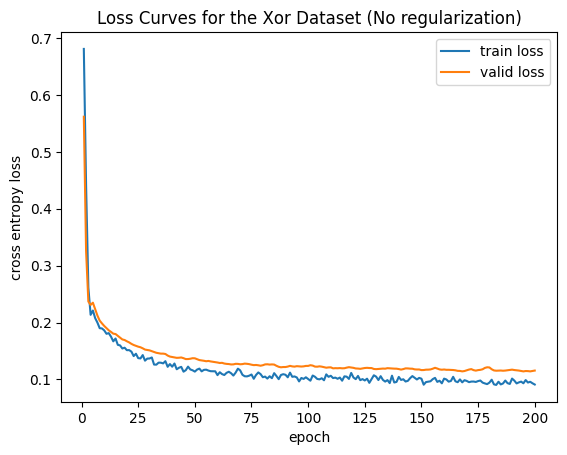

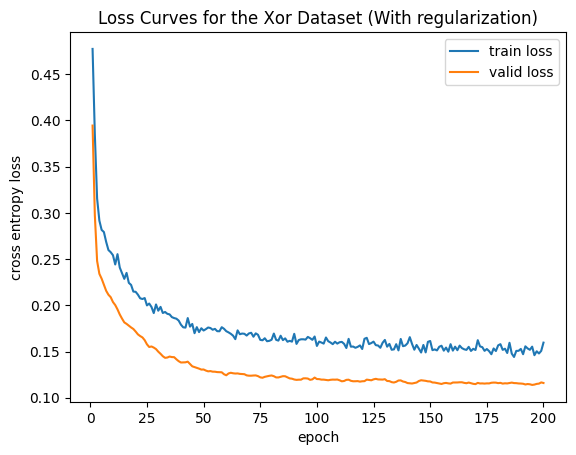

In [55]:
plot_loss_curves(train_losses_no_reg, valid_losses_no_reg, postfix="No regularization")
plot_loss_curves(train_losses_with_reg, valid_losses_with_reg, postfix="With regularization")

/var/folders/0b/t_zq87x958lc5wvb065nb89m0000gn/T/ipykernel_67597/3787403718.py:18: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labels[idx], dtype=torch.long)


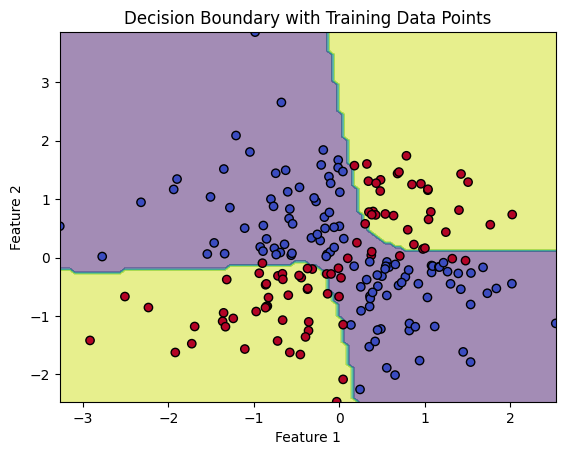

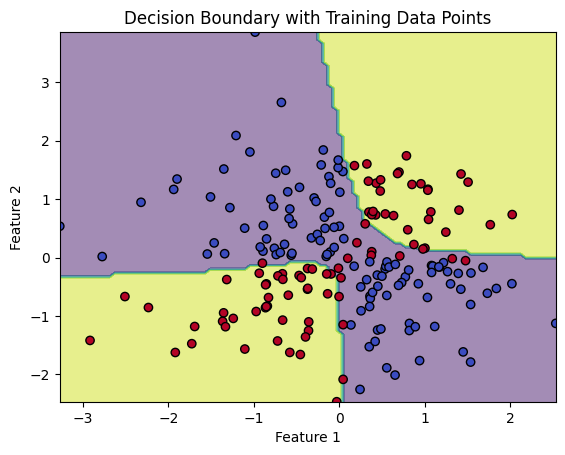

In [56]:
plot_decision_boundaries(model_no_reg, title=f"-Unregularized- Dataset: {csv_file_prefix.capitalize()}, Nodes: {hidden_size}, Cost Function: MSE")
plot_decision_boundaries(model_with_reg, title=f"-Regularized- Dataset: {csv_file_prefix.capitalize()}, Nodes: {hidden_size}, Cost Function: MSE")